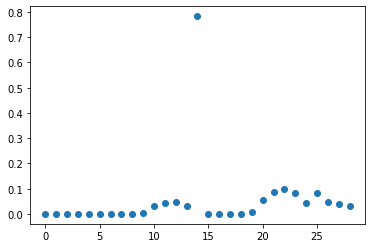

In [4]:
import dill as pickle
import matplotlib.pyplot as plt

loc_id = 555

with open(f'/ihme/covid-19/deaths/dev/2020_04_23_US_gm_17/model_data_google_21/{loc_id}/gaussian_mixtures.pkl', 'rb') as fopen:
    gm = pickle.load(fopen)

plt.scatter(np.arange(gm[f'_{loc_id}'].weights.size),
            gm[f'_{loc_id}'].weights)
plt.show()


In [6]:
gm[f'_{loc_id}'].weights.sum()

0.8587875822130603

In [ ]:
import pandas as pd
from functools import reduce

cov_dfs = []
for submod in ['google', 'equal', 'ascmid', 'ascmax']:
    cov_df = pd.read_csv(f'/ihme/covid-19/deaths/dev/2020_04_11_Europe_new_cov/model_data_{submod}_21/Netherlands covariate.csv')
    cov_df = cov_df.loc[~cov_df['threshold_date'].isnull()]
    cov_df = cov_df.rename(index=str, columns={'cov_1w':submod})
    cov_dfs.append(cov_df[['Location', submod]])
cov_df = reduce(lambda x, y: pd.merge(x, y), cov_dfs)

In [ ]:
cov_df.loc[cov_df['Location'].isin(['Denmark', 'Netherlands', 'Norway'])].to_csv('/ihme/homes/rmbarber/N_Euro_covs.csv', index=False)

In [ ]:
import dill as pickle

with open(f'/ihme/covid-19/deaths/prod/2020_04_22_Europe/model_data_google_21/123/draws.pkl', 'rb') as fopen:
    draws = pickle.load(fopen)


In [ ]:
import os

import dill as pickle

import numpy as np
import pandas as pd

from scipy.signal import resample

import matplotlib.pyplot as plt


location_name = 'California'
location_id = '_527'
pop = 36.9e6
n_draws = 111

with open(f'/ihme/covid-19/deaths/prod/2020_04_13_US/model_data_equal_21/{location_name}/draws.pkl', 'rb') as fopen:
    draws = pickle.load(fopen)

orig_draws = np.exp(draws[location_id][1]) * pop
# ds_draws = np.arange(orig_draws.shape[0], step=orig_draws.shape[0]/n_draws)
# ds_draws = [int(i) for i in ds_draws]
# assert len(ds_draws) == n_draws, 'Draw length not correct.'
# downsample_draws = orig_draws[ds_draws]
downsample_draws = resample(orig_draws, n_draws, axis=0)
downsample_draws = downsample_draws[np.argsort(downsample_draws[:,-1]),:]

orig_draws = orig_draws[:,1:] - orig_draws[:,:-1]
downsample_draws = downsample_draws[:,1:] - downsample_draws[:,:-1]

plt.figure(figsize=(11, 8.5))
plt.fill_between(draws[location_id][0][1:],
                np.percentile(orig_draws, 2.5, axis=0),
                np.percentile(orig_draws, 97.5, axis=0),
                color='dodgerblue', alpha=0.5)
plt.plot(draws[location_id][0][1:],
         orig_draws.mean(axis=0), color='dodgerblue', label='Full draws')
plt.fill_between(draws[location_id][0][1:],
                np.percentile(downsample_draws, 2.5, axis=0),
                np.percentile(downsample_draws, 97.5, axis=0),
                color='firebrick', alpha=0.5)
plt.plot(draws[location_id][0][1:],
         downsample_draws.mean(axis=0), color='firebrick', label='Downsampled draws', linestyle='--')
plt.legend(loc=2)
plt.show()


In [ ]:
?resample

In [ ]:

google_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_13_US_mobility_closure_w/model_data_google_21/California covariate.csv')
descartes_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_13_US_mobility_closure_w/model_data_descartes_21/California covariate.csv')
safegraph_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_13_US_mobility_closure_w/model_data_safegraph_21/California covariate.csv')


In [ ]:
google_df

In [ ]:
descartes_df

In [ ]:
safegraph_df

In [ ]:
# map of closure codes to names
code_map = {'ci_sd1':'People instructed to stay at home', 
            'ci_sd2':'Educational facilities closed', 
            'ci_sd3':'Non-essential services closed (i.e., bars/restaurants)', 
            'ci_psd1':'Any Gathering Restrictions', 
            'ci_psd3':'Any Business Closures'}

weight_dfs = []
for empirical_weight_source in ['google', 'descartes', 'safegraph']:
    # load data, just keep average
    weight_df = pd.read_csv('/ihme/homes/xdai88/sd_effect/effs_on_DL_GLavg_SG.csv')
    weight_df = weight_df.loc[weight_df['statistic'] == 'mean']
    if empirical_weight_source == 'google':
        weight_df = weight_df.loc[weight_df['metric'] == 'Google_avg_of_retail_transit_workplace']
    elif empirical_weight_source == 'descartes':
        weight_df = weight_df.loc[weight_df['metric'] == 'Descartes_absolute_travel_distance']
    elif empirical_weight_source == 'safegraph':
        weight_df = weight_df.loc[weight_df['metric'] == 'Safegraph_time_outside_home']
    else:
        raise ValueError('Invalid `empirical_weight_source` provided.')

    # set to proportional reduction (i.e., positive, out of 1)
    weight_df[list(code_map.keys())] = weight_df[list(code_map.keys())].values

    # remove partial effect from full (will use these as compounding in weighting)
    weight_df['ci_sd1'] = weight_df['ci_sd1'] - weight_df['ci_psd1']
    weight_df['ci_sd3'] = weight_df['ci_sd3'] - weight_df['ci_psd3']
    weight_df = pd.melt(weight_df, 
                        id_vars=['metric'], 
                        value_vars=list(code_map.keys()),
                        var_name='closure_code',
                        value_name='effect')
    weight_df['closure_name'] = weight_df['closure_code'].map(code_map)
    weight_denom = weight_df['effect'].sum()
    weight_df['weight'] = weight_df['effect'] / weight_denom
    weight_df['source'] = empirical_weight_source
    weight_dfs.append(weight_df)
    
weight_df = pd.concat(weight_dfs)


In [ ]:
df = pd.pivot_table(weight_df, index='source', columns='closure_name', values='weight').reset_index()
df.to_csv('/ihme/homes/rmbarber/mobility_weights.csv', index=False)